<a href="https://colab.research.google.com/github/jeawonlll/KOHI2022_tutorials/blob/main/20220823/02_build_medical_algorithm_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료인공지능 전문가 양성과정 2022

## Building medical algorithm Hands-on

- Date: Aug. 13, 2022
- Author: **Hyun-Lim Yang, Ph.D.** <br>
  Research Assistant Professor @ Seoul National University Hospital
- E-mail: hlyang{at}snu{dot}ac{dot}kr

***

## 0. Goal

#### 생체신호 분석 및 medical algorithm 구현

본 강의에서는 **생체신호 데이터를 분석하여 anesthesia nociception index(ANI)를 구현**해봅니다.


In [1]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab

Mounted at /content/gdrive/


In [2]:
import os
cloud_directory = '/content/gdrive/My Drive/KOHI_base_2022/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

['example_data']

In [3]:
import sys
download_directory = os.getcwd() # for local environments
sys.path.append(download_directory) # for local environments
sys.path.append(cloud_directory) # for colab

download_directory = cloud_directory # for colab

***

## 1. Background and Preparation

ANI는 전신마취 하 수술 중 통각 모니터링 및 진통을 위해 활용되는 지표입니다.<br>
ECG 신호를 처리하여 값을 구할 수 있습니다.<br>


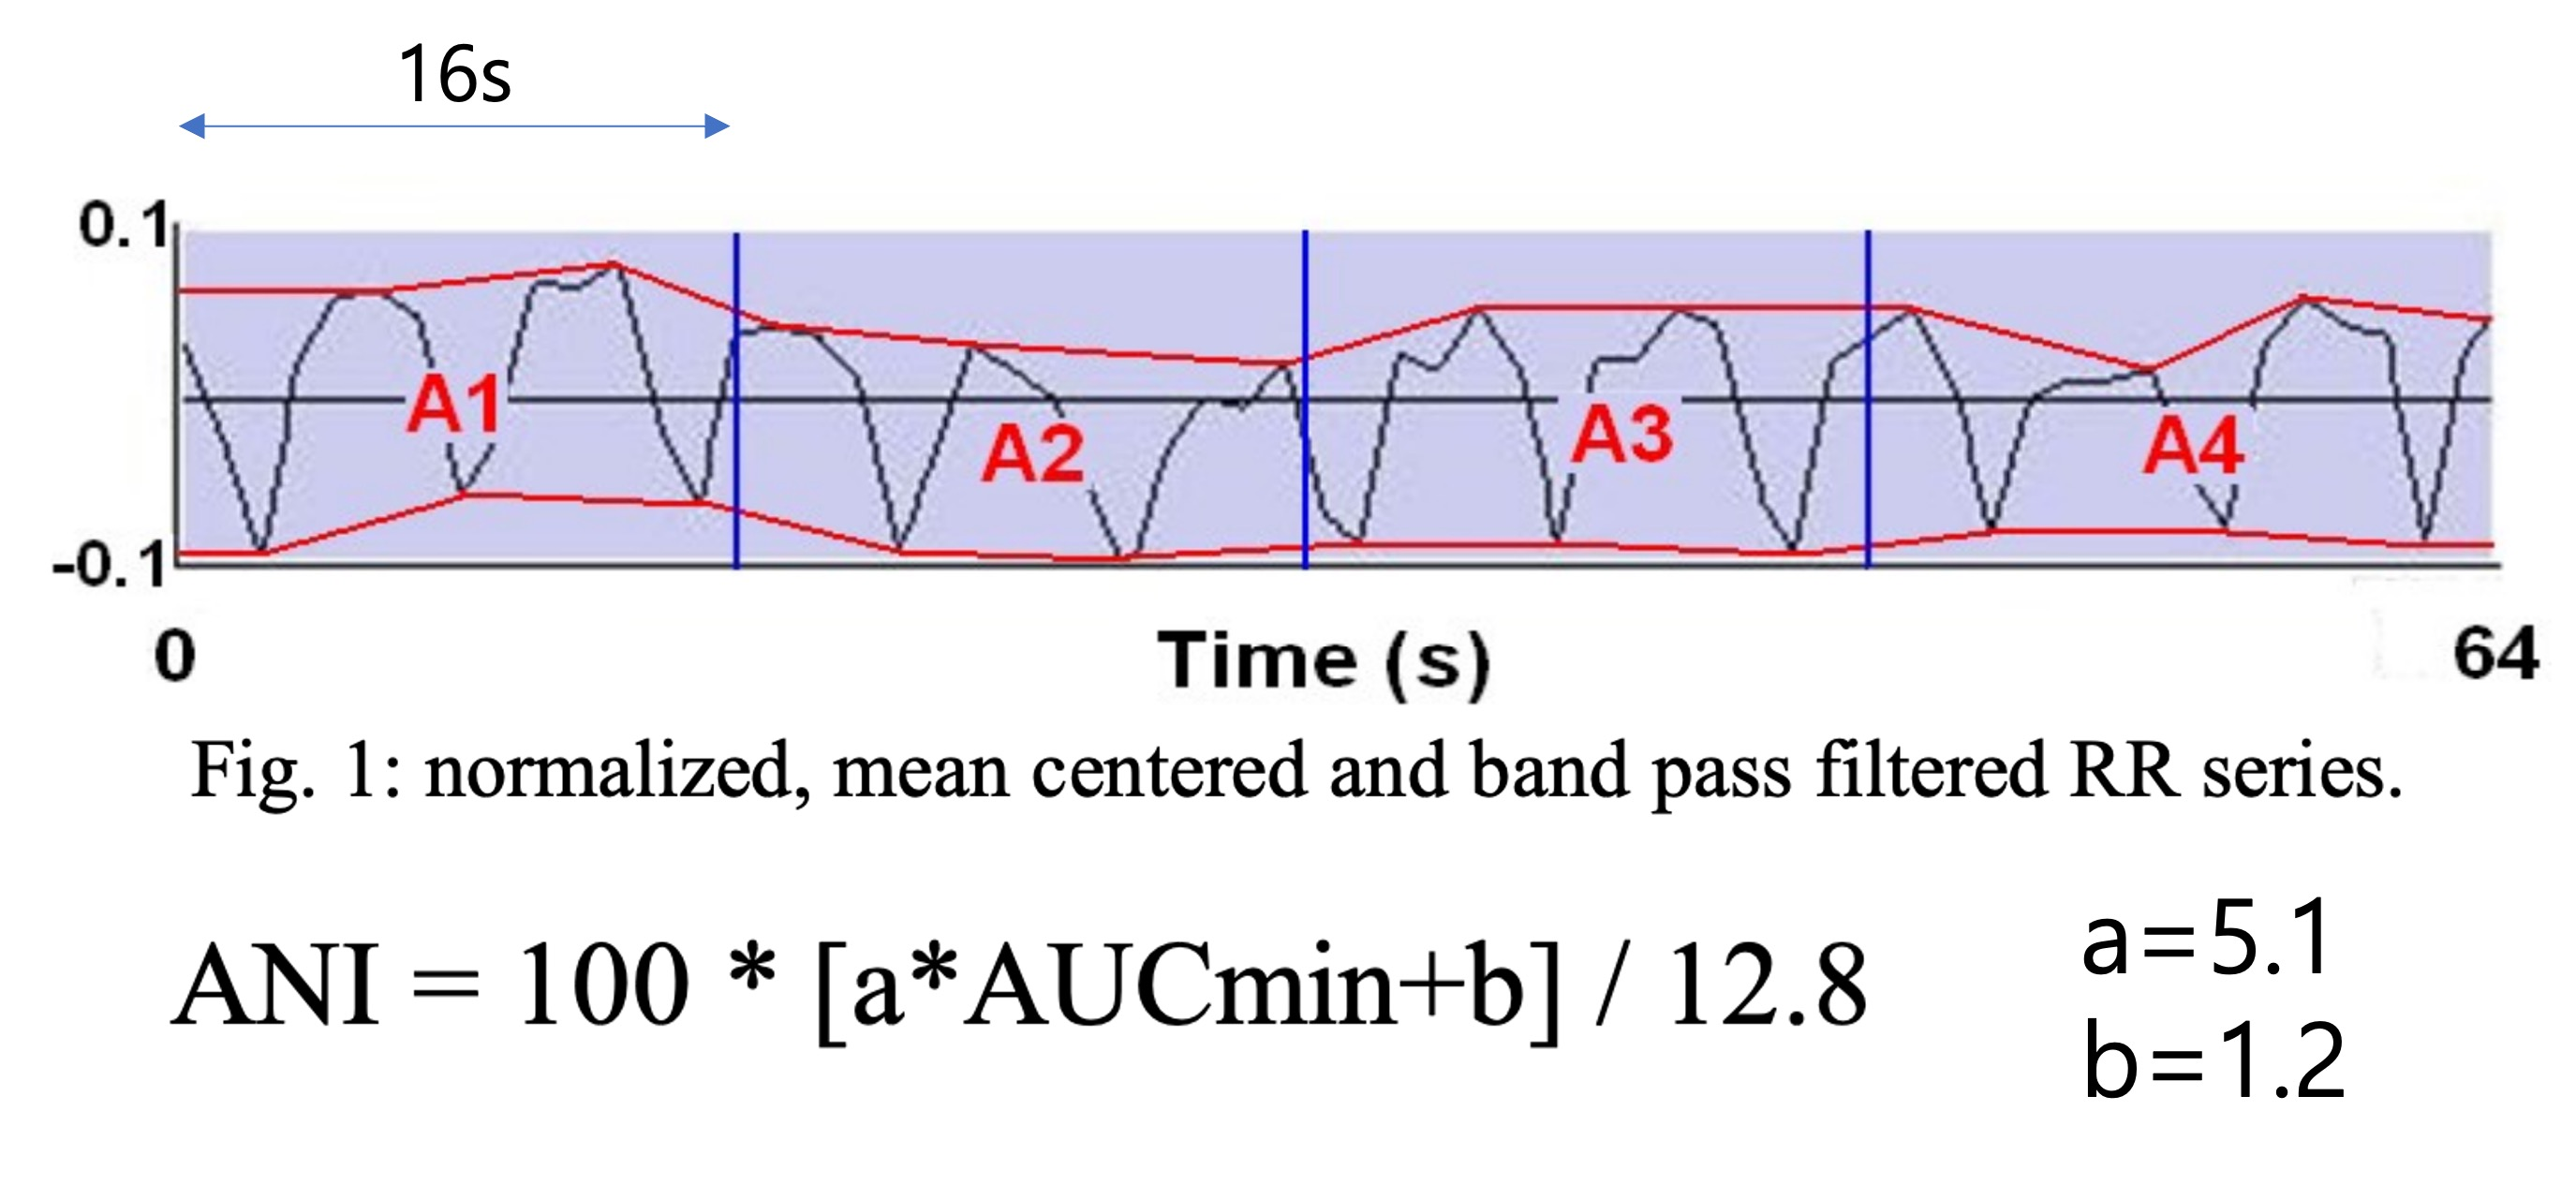

In [4]:
from IPython.display import Image
Image(filename="{}/example_data/ani_description.jpg".format(download_directory))

In [5]:
!pip install vitaldb
!pip install neurokit2
!pip install heartpy
!pip install pyvital

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 159 kB 9.7 MB/s 
     |████████████████████████████████| 66 kB 5.3 MB/s 
     |████████████████████████████████| 9.1 MB 63.6 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB

In [6]:
import vitaldb
import pyvital.arr as arr
import numpy as np
import pandas as pd
import os
import heartpy as hp
import neurokit2 as nk
import glob
import matplotlib.pylab as plt
import scipy
import scipy.signal
import scipy.interpolate
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings(action='ignore')

***

## 2.Data loading

샘플 파일을 드라이브로부터 불러오기

In [7]:
sampling_rate = 100

sample_vital = vitaldb.vital_recs('{}/example_data/sample_vital_ani_2.vital'.format(download_directory), interval=1/sampling_rate, track_names=['SNUADC/ECG_II', 'ANIMonitor2/ANIm'])

ECG 데이터와 ANI Plotting

Text(0, 0.5, 'ANI value')

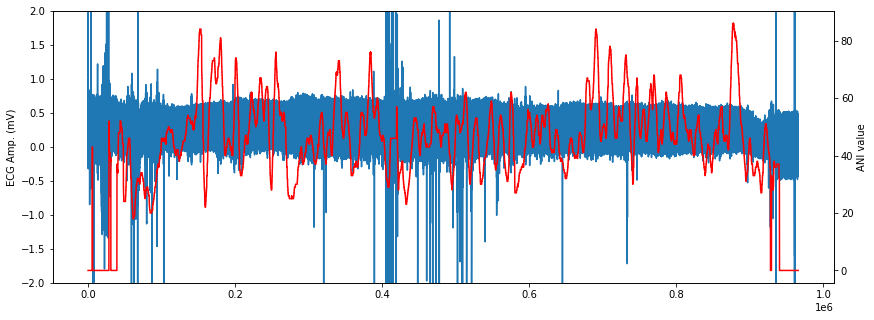

In [8]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(sample_vital[:,0], label='ECG_II')
ax.set_ylabel('ECG Amp. (mV)')
ax.set_ylim([-2, +2])

ani_ffill = arr.replace_undefined(sample_vital[:,1]) # [np.nan, 1, 2, 3, np.nan, np.nan, 4, 5, np.nan] -> [1,1,2,3,3,3,4,5,5]
ax2 = ax.twinx()
ax2.plot(ani_ffill, label='ANI', color='r')
ax2.set_ylabel('ANI value')

실제 수술 환경 데이터에서는 수술 전후에 많은 노이즈가 발생할 수 있으므로 앞 뒤데이터를 삭제합니다.<br>
여기서는 앞뒤 20분의 데이터를 지우겠습니다.

Text(0, 0.5, 'ANI value')

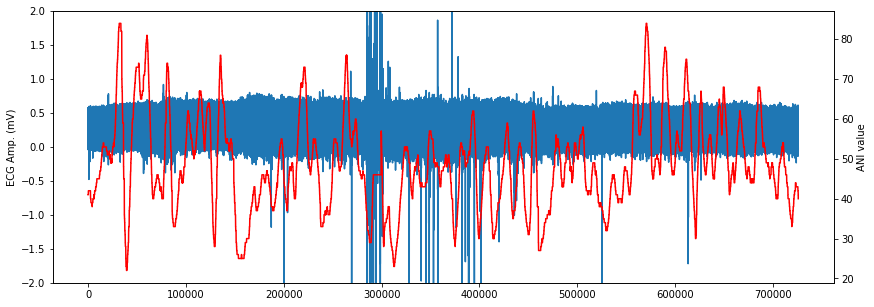

In [9]:
# Remove front and back 20 minutes of data that may contain noise
new_sample_vital = sample_vital[20*60*100 : -(20*60*100)]

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(new_sample_vital[:,0], label='ECG_II')
ax.set_ylabel('ECG Amp. (mV)')
ax.set_ylim([-2, +2])

ani_ffill = arr.replace_undefined(new_sample_vital[:,1]) # [np.nan, 1, 2, 3, np.nan, np.nan, 4, 5, np.nan] -> [1,1,2,3,3,3,4,5,5]
ax2 = ax.twinx()
ax2.plot(ani_ffill, label='ANI', color='r')
ax2.set_ylabel('ANI value')


***
## 3. Data filtering

샘플 데이터를 64초 가져와서 ECG 데이터 필터링을 수행합니다. <br>
단, 추후 신호처리의 부정확성 문제 해결과 enveolpe 추정 시 정확도 향상을 위해 신호의 뒤에 8초의 buffer를 포함해서 가져옵니다.

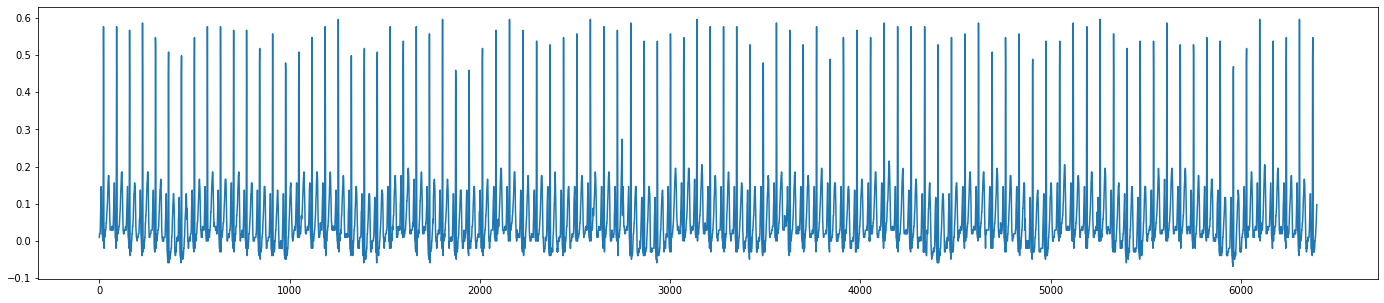

In [10]:
# extract sample ECG with buffer of 8s each, total 16s
start_idx = 5000

segment_64 = new_sample_vital[start_idx:start_idx + 64*100 + 16*100]
ecg_segment = segment_64[:,0]
ani_segment = segment_64[:,1]

fig = plt.figure(figsize=(24, 5))
plt.plot(ecg_segment[8*100:-8*100])

#### **TODO**: ECG의 normal range 주파수인 0.5 ~ 45Hz 만을 남기도록 bandpass filtering 을 수행합니다.

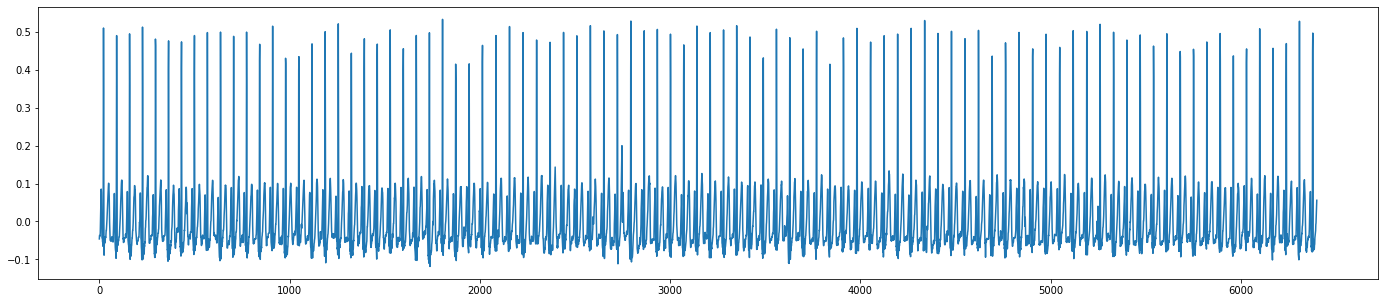

In [ ]:
# process 1: filter the ECG with butterworth bandpass using frequency range of [0.5 - 45] (normal ECG range)

#=========== YOUR CODE HERE ========================

filtered_ecg_segment = 

#===================================================

fig = plt.figure(figsize=(24, 5))
plt.plot(filtered_ecg_segment[8*100:-8*100])


필터 전과 필터 후를 비교하면 low frequency 대역의 주파 (호흡 등에 의한 변동)이 잡힌것을 확인할 수 있습니다.

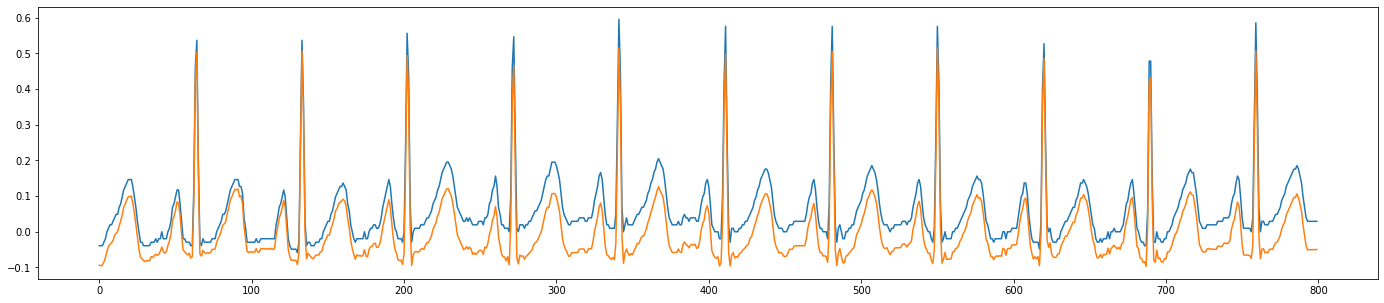

In [ ]:
plt.figure(figsize=(24,5))
plt.plot(ecg_segment[36*100:44*100])
plt.plot(filtered_ecg_segment[36*100:44*100])

***

## 4. R-peak detection and calculate ECG rate

In [11]:
# detect r_peaks
r_peaks = arr.detect_qrs(filtered_ecg_segment, sampling_rate)

fig = plt.figure(figsize=(24,5))
plt.plot(filtered_ecg_segment, color='b')
plt.scatter(y=filtered_ecg_segment[r_peaks], x=[r_peaks], color='r', s=50)

NameError: ignored

In [ ]:
# find ecg rate
ecg_rate_segment = nk.ecg_rate(r_peaks, sampling_rate=100, desired_length=len(filtered_ecg_segment))

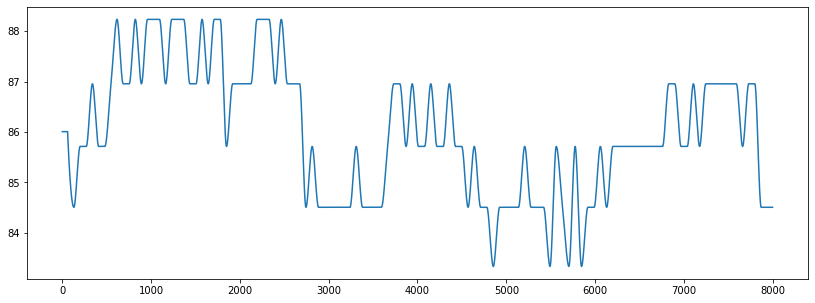

In [ ]:
fig = plt.figure(figsize=(14, 5))
plt.plot(ecg_rate_segment)

***

## 5. ECG derived Respiration (EDR) calculation
Extract ECG-Derived Respiration (EDR), a proxy of a respiratory signal based on heart rate.

In [ ]:
edr_segment = nk.ecg_rsp(ecg_rate_segment, sampling_rate=sampling_rate)

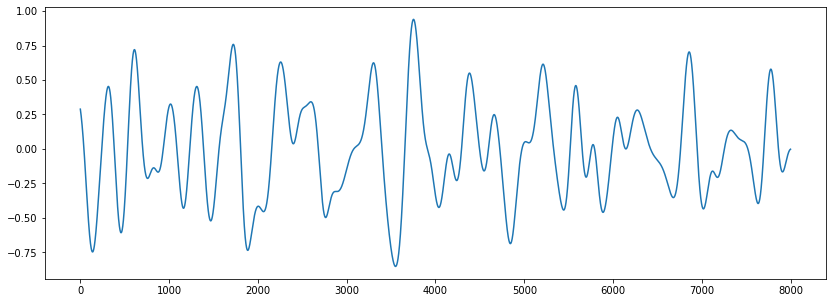

In [ ]:
fig = plt.figure(figsize=(14, 5))
plt.plot(edr_segment)

> 참고: compare multiple EDR methods

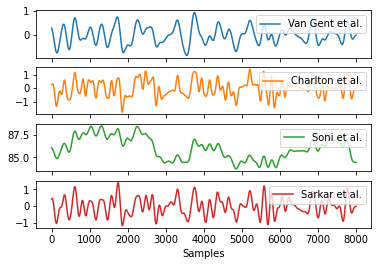

In [ ]:
# cf) compare multiple EDR methods
edr_df = pd.DataFrame({
    "Van Gent et al.": nk.ecg_rsp(ecg_rate_segment, sampling_rate=100),
    "Charlton et al." : nk.ecg_rsp(ecg_rate_segment, sampling_rate=100, method="charlton2016"),
    "Soni et al.": nk.ecg_rsp(ecg_rate_segment, sampling_rate=100, method="soni2019"),
    "Sarkar et al.": nk.ecg_rsp(ecg_rate_segment, sampling_rate=100, method="sarkar2015")
    })

nk.signal_plot(edr_df, subplots=True)

#### Resample Hz to 8

In [ ]:
# resample to 8 Hz
edr_segment_8hz = arr.resample_hz(edr_segment, sampling_rate, 8)

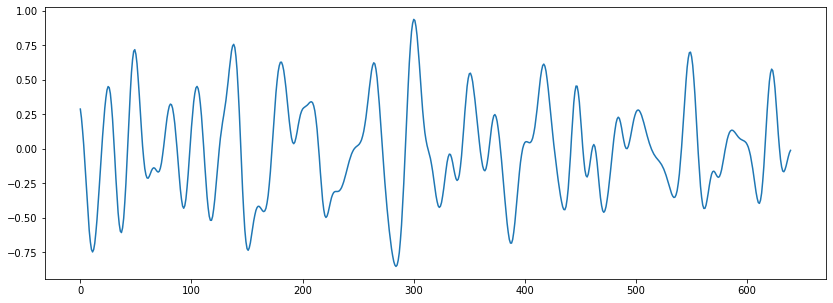

In [ ]:
fig = plt.figure(figsize=(14, 5))
plt.plot(edr_segment_8hz)

***
## 6. Respiration Filtering
#### **TODO**: Filter the respiration with frequency range of 0.15 ~ 0.4, with oder of 2 butterworth

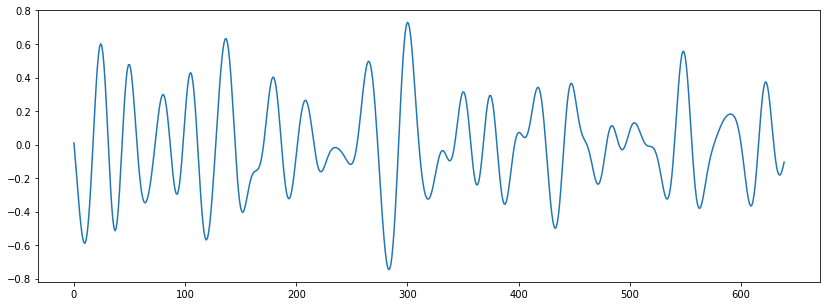

In [ ]:
# bandpass with butterworth cutoff of [0.15 - 0.4], order of 2

#=========== YOUR CODE HERE ========================

edr_segment_8hz_bp = 

#===================================================

fig = plt.figure(figsize=(14, 5))
plt.plot(edr_segment_8hz_bp)

***
## 7. Normalization
Normalize signal to -0.1 ~ 0.1

In [ ]:
def normalization(array, range_a=-0.1, range_b=0.1):
    min_x = np.min(array)
    max_x = np.max(array)
    
    new_arr = (((range_b-range_a)*(array - min_x)) / (max_x - min_x)) + range_a
    return new_arr

In [ ]:
# do normalize [-0.1 ~ 0.1]
edr_segment_8hz_bp_norm = normalization(edr_segment_8hz_bp, -0.1, 0.1)

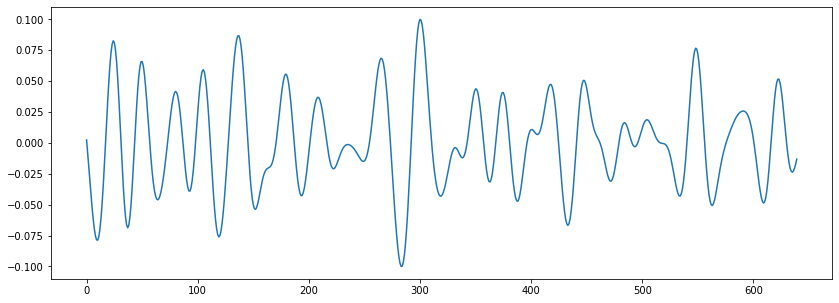

In [ ]:
fig = plt.figure(figsize=(14, 5))
plt.plot(edr_segment_8hz_bp_norm)

*** 

## 8. Find peak and valley of respiratory wave, and estimate envolope

#### find peak (using neurokit2)

In [ ]:
# find peak and troughs from respiratory wave
rsp_signal, rsp_peaks = nk.rsp_peaks(edr_segment_8hz_bp_norm, sampling_rate=8)

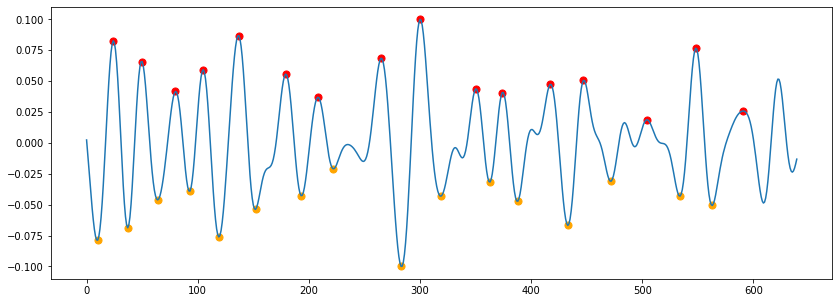

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(edr_segment_8hz_bp_norm)
plt.scatter(y=edr_segment_8hz_bp_norm[rsp_peaks['RSP_Peaks']], x=rsp_peaks['RSP_Peaks'], color='r', s=50)
plt.scatter(y=edr_segment_8hz_bp_norm[rsp_peaks['RSP_Troughs']], x=rsp_peaks['RSP_Troughs'], color='orange', s=50)

#### estimate envelope (using scipy)
envelope 추정의 정확도 향상을 위해 peak 혹은 valley가 detect된 영역 내에서만 추정

In [ ]:
# estimate envelope
idx_start = max(min(rsp_peaks['RSP_Troughs']), min(rsp_peaks['RSP_Peaks']))
idx_end = min(max(rsp_peaks['RSP_Troughs']), max(rsp_peaks['RSP_Peaks']))

lower_envelope = scipy.interpolate.interp1d(rsp_peaks['RSP_Troughs'], edr_segment_8hz_bp_norm[rsp_peaks['RSP_Troughs']])(np.arange(idx_start, idx_end))

잔여 구간은 기존 값 활용

In [ ]:
lower_envelope_interp = np.concatenate([edr_segment_8hz_bp_norm[:idx_start], lower_envelope, edr_segment_8hz_bp_norm[idx_end:]])

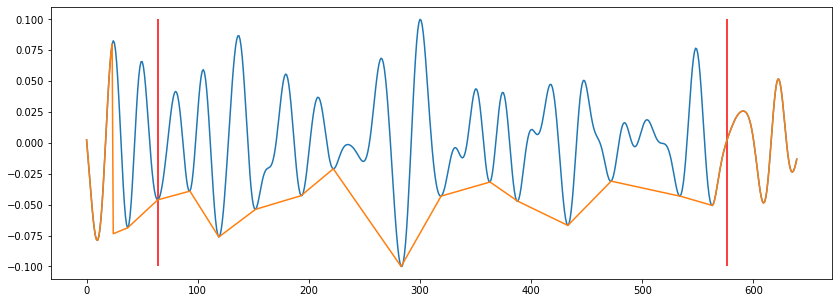

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(edr_segment_8hz_bp_norm)
plt.plot(lower_envelope_interp)

plt.vlines(x = 8*8, ymin = -0.1, ymax = 0.1,
           colors = 'red',
           label = 'buffer')
plt.vlines(x = len(edr_segment_8hz_bp_norm)-8*8, ymin = -0.1, ymax = 0.1,
           colors = 'red',
           label = 'buffer')

***

## 9. AUC 계산 및 ANI 계산
적분을 대신하여, respiratory wave에서 lower envelope을 뺀 뒤 모든 영역을 더하는 적분 (리만적분)을 수행합니다.<br>
부정확한 buffer를 제거하고 중간에 있는 데이터만 활용합니다.

In [ ]:
# extract region of what we have interest
edr_segment_roi = edr_segment_8hz_bp_norm[8*8:-8*8]
lower_envelope_roi = lower_envelope_interp[8*8:-8*8]

# calculate AUC in each point
diff_edr_le = edr_segment_roi - lower_envelope_roi
diff_edr_le[diff_edr_le<0] = 0

In [ ]:
# calculate each AUC

AUC1 = diff_edr_le[:1*16*8].sum() / 8
AUC2 = diff_edr_le[1*16*8:2*16*8].sum() / 8
AUC3 = diff_edr_le[2*16*8:3*16*8].sum() / 8
AUC4 = diff_edr_le[3*16*8:4*16*8].sum() / 8

In [ ]:
AUCmin = np.min(np.array([AUC1, AUC2, AUC3, AUC4]))

In [ ]:
ANI_calc = 100 * (5.1 * AUCmin + 1.2) / 12.8

print(ANI_calc)

34.68634030694307


***

## 00. 전체 수술 기간동안의 변화폭 확인

ANI 모니터에서 사용하는 ECG 센서와 vitalDB에서 수집된 ECG센서의 종류가 다르고 부착 위치가 다르니 제안된 ANI 수식에서 활용되는 파라미터 (a, b) 값이 달라 ANI 장비의 값과 동일한 값은 얻을 수 없습니다.<br>
그러나 위 코드의 내용을 함수화시키고 수술 전체에 적용해봄으로써 환자의 통증 변화는 가늠해볼 수 있습니다.<br>
본 강좌의 코드에서는 편의를 위해 try-except 구문을 통해 제대로 처리되지 않는 이상신호들을 모두 무시하였지만, 실제 구현시에는 보다 엄밀한 전처리 및 오류 보정으로 모든 가능한 에러를 처리해야 실제 현장에 적용할 수 있습니다.


In [ ]:
# modulize

def calc_ANI_from_segment(segment, sampling_rate, buffer_size):
    if not len(segment) == 64*sampling_rate + 2*buffer_size*sampling_rate:
        raise ValueError('segment size mismatched. required: 64s + 2*buffer_size, however, input was {}s'.format(int(len(segment)/sampling_rate)))
        
    # calc edr
    bandpass_filtered = arr.band_pass(segment, srate=sampling_rate, fl = 0.5, fh = 45)
    r_peaks = arr.detect_qrs(bandpass_filtered, sampling_rate)
    ecg_rate = nk.ecg_rate(r_peaks, sampling_rate=100, desired_length=len(bandpass_filtered))
    edr = nk.ecg_rsp(ecg_rate, sampling_rate=100)
    edr = arr.resample_hz(edr, 100, 8)
    edr = arr.band_pass(edr, srate=8, fl = 0.15, fh = 0.4, order=2)
    edr = normalization(edr, -0.1, 0.1)
    
    # process resp
    resp_signal, resp_info = nk.rsp_peaks(edr, sampling_rate=8)
    peak_idx_start = max(min(resp_info['RSP_Troughs']), min(resp_info['RSP_Peaks']))
    peak_idx_end = min(max(resp_info['RSP_Troughs']), max(resp_info['RSP_Peaks']))
    lower_envelop = scipy.interpolate.interp1d(resp_info['RSP_Troughs'], edr[resp_info['RSP_Troughs']])(np.arange(peak_idx_start, peak_idx_end))
    lower_envelop = np.concatenate([edr[:peak_idx_start], lower_envelop, edr[peak_idx_end:]])
    
    # remove buffer and extract clean range
    edr_clean = edr[buffer_size*8:-buffer_size*8]
    lower_envelop_clean = lower_envelop[buffer_size*8:-buffer_size*8]
    diff_edr_le = edr_clean - lower_envelop_clean
    diff_edr_le[diff_edr_le<0] = 0
    
    # calc ANI from AUC in 4 segment
    AUC1 = diff_edr_le[:1*16*8].sum() / 8
    AUC2 = diff_edr_le[1*16*8:2*16*8].sum() / 8
    AUC3 = diff_edr_le[2*16*8:3*16*8].sum()/ 8
    AUC4 = diff_edr_le[3*16*8:].sum() / 8
    AUC_min = np.min(np.array([AUC1, AUC2, AUC3, AUC4]))
    ANI = 100*(5.1*AUC_min+1.2) / 12.8
    
    if ANI > 100:
        ANI = 100

    return ANI

In [ ]:
def plot_ani_calc(filename):
    sample_vital = vitaldb.vital_recs(filename, interval=1/sampling_rate, track_names=['SNUADC/ECG_II', 'ANIMonitor2/ANIm'])
    new_sample_vital = sample_vital[20*60*100 : -(20*60*100)]

    ecg_whole = new_sample_vital[:,0]
    buffer_size_each = 12
    clean_segment_length = 64
    chunk_length = (12*2 + 64) * sampling_rate
    buffer_length = 12 * sampling_rate
    chunked_ecg = [ecg_whole[i:i+chunk_length] for i in range(0, len(ecg_whole), chunk_length-buffer_length)]
    chunked_ecg = np.vstack(chunked_ecg[:-2])


    ANI_list = []
    for segment in chunked_ecg:    
        try:
            ani = calc_ANI_from_segment(segment, 100, 12)
            ANI_list.append(ani)
        except:
            ANI_list.append(np.nan)
            
            
    ANI_np = np.array(ANI_list)
    ANI_np = arr.replace_undefined(ANI_np)

    ANI_true = arr.replace_undefined(new_sample_vital[:,1]) # [np.nan, 1, 2, 3, np.nan, np.nan, 4, 5, np.nan] -> [1,1,2,3,3,3,4,5,5]
    ani_true_ds = arr.resample_hz(ANI_true, 100, 0.015)
    smoothing_true = lowess(ani_true_ds, np.arange(0, len(ani_true_ds)), frac=0.05)

    smoothing_calc = lowess(ANI_np, np.arange(0, len(ANI_np)), frac=0.05)
    pad_ani_calc = np.pad(ANI_np, (int((len(smoothing_true)-len(ANI_np))/2), int((len(smoothing_true)-len(ANI_np))/2)), mode='edge')
    smoothing_calc_pad = lowess(pad_ani_calc, np.arange(0, len(pad_ani_calc)), frac=0.05)

    fig, ax = plt.subplots(figsize=(14,5))
    ax.plot(ani_true_ds, color='skyblue')
    ax.plot(smoothing_true[:,1], color='b', label='ANI monitor')

    ax2 = ax.twinx()
    ax2.plot(pad_ani_calc, color='pink')
    ax2.plot(smoothing_calc_pad[:,1], color='r', label='ANI calc')
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.show()

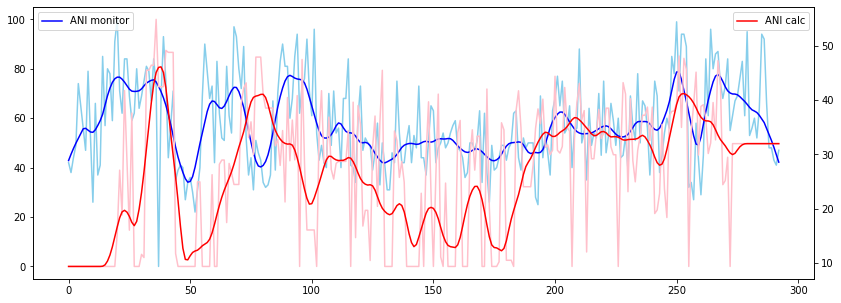

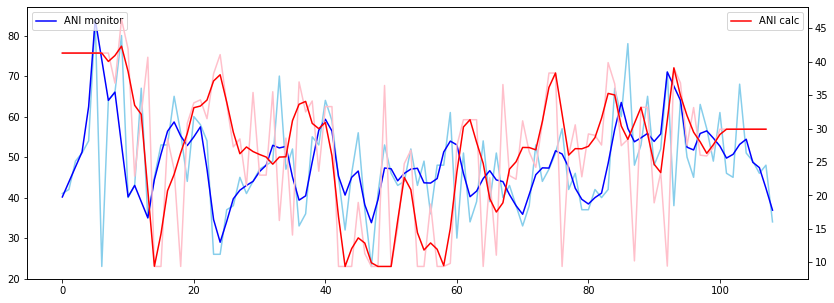

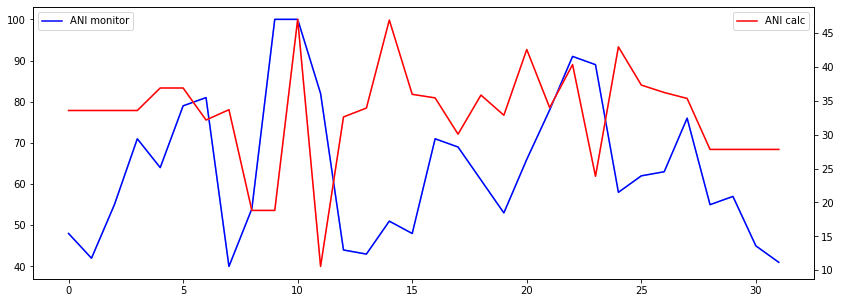

In [ ]:
filelist = ['{}/example_data/sample_vital_ani_1.vital'.format(download_directory), 
            '{}/example_data/sample_vital_ani_2.vital'.format(download_directory), 
            '{}/example_data/sample_vital_ani_3.vital'.format(download_directory)]

for fname in filelist:
    plot_ani_calc(fname)